In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import permutations
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import PercentFormatter

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(1)

# Set parameters

In [2]:
n = 1000 # sample size
c = 0.3 # p/n
alpha = 0.1 # L/n
beta = alpha/c

p = int(c*n) # dimension
L = int(alpha*n) # band size
setting = "$n = {} \quad p = {} \quad L = {}$".format(n, p, L)

easy_setting = False

if easy_setting:
    k = 2 # number of classes
    pi = np.array([0.5, 0.5]) # proportion of each class
    # centroid of each class
    mu = stats.norm.rvs(size=(p, 1))
    mu_norm = 2
    mu = mu_norm*mu/np.linalg.norm(mu)
    M = np.concatenate([+mu, -mu], axis=1)
    setting += "$\quad || \mu || = {}$".format(mu_norm)
else:
    k = 3 # number of classes
    pi = np.array([0.34, 0.33, 0.33]) # proportion of each class
    # centroid of each class
    cov_mat = np.kron(np.array([[10., 5.5, 2.], [5.5, 15., 4.], [2., 4., 12.]]), np.eye(p))/p
    M = stats.multivariate_normal.rvs(cov=cov_mat).reshape((p, k))
    min_mu_norm = 10
    M = min_mu_norm*M/np.sqrt(np.diag((M.T)@M)).min()

J = utils.getJ(n, pi)
nbMC = 1 # number of Monte-Carlo simulations

streaming = True
T = 10*n # number of points seen during streaming
animation = False
t_anim = 30 # duration of the animation in seconds

# Computations

**Limiting spectral distribution**: we use the fact that, if $m$ is the Stieltjes transform of a measure which has a density $d(x)$ in $x$, then
$$
d(x) = \frac{1}{\pi} \lim_{y \downarrow 0} \Im \left[ m(x + \mathrm{i} y) \right].
$$

In [3]:
# Simulations
eigvals_t, eigvecs_t = utils.simul(nbMC, L, M, J, mask='toeplitz', comp=False)
eigvals_c, eigvecs_c = utils.simul(nbMC, L, M, J, mask='circulant', comp=False)

100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


In [4]:
# Get eigenbases
tau, basis_t = utils.basis(n, L, kind='toeplitz')
psi, basis_c = utils.basis(n, L, kind='circulant')

In [5]:
# Limiting spectral distribution
axr = np.linspace(eigvals_c.min(), eigvals_c.max(), 1000)
eta0_t = utils.eta0(axr, n, p, L, tau)
eta0_c = utils.eta0(axr, n, p, L, psi)
LSD_t = (1/(1-axr-eta0_t)).imag/np.pi
LSD_c = (1/(1-axr-eta0_c)).imag/np.pi

100%|██████████| 1000/1000 [00:01<00:00, 582.27it/s]


In [6]:
# Get spikes and alignments
if easy_setting:
    spikes_c, spikes_t = utils.get_spikes(n, p, L, mu_norm)
    spikes_idx_c, spikes_c, zeta_c, natural_idx_c = spikes_c
    spikes_idx_t, spikes_t, zeta_t, natural_idx_t = spikes_t

# Visualisation

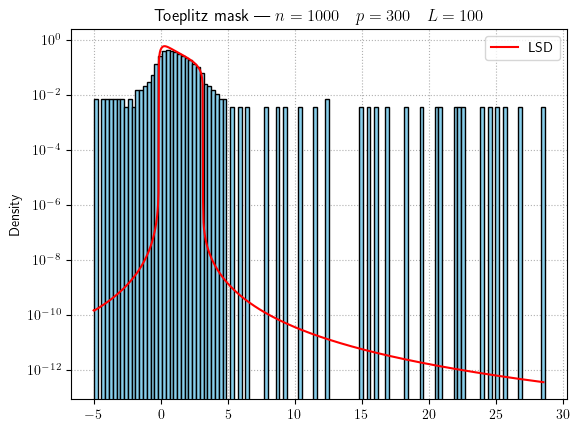

In [7]:
plt.hist(eigvals_t.flatten(), bins='auto', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_t, color='red', label="LSD")
if easy_setting:
    for spike in spikes_t:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Toeplitz mask | "+setting)
plt.show()

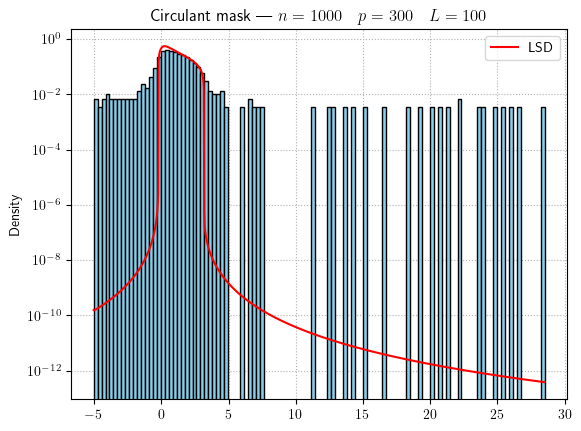

In [8]:
plt.hist(eigvals_c.flatten(), bins='auto', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_c, color='red', label="LSD")
if easy_setting:
    for spike in spikes_c:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Circulant mask | "+setting)
plt.show()

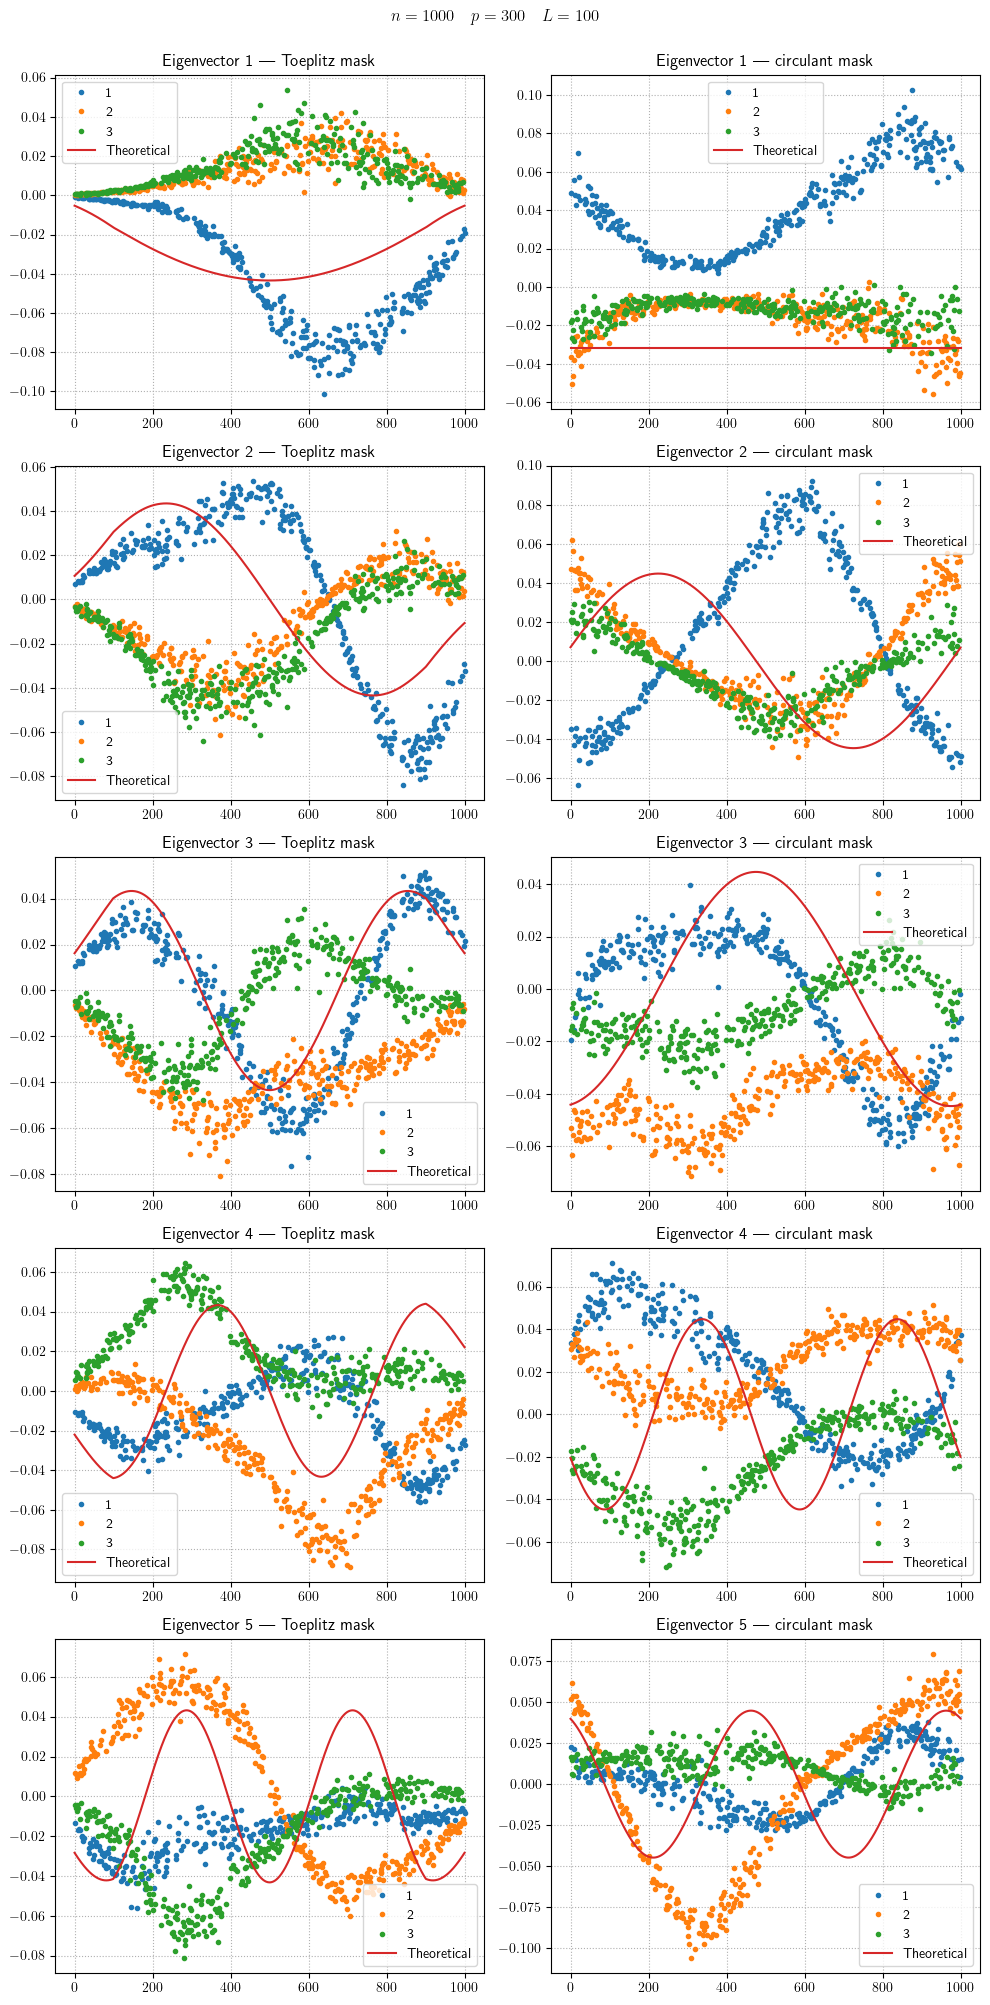

In [9]:
x = np.arange(n)
n_to_plot = 5
to_plot = spikes_idx_t[:n_to_plot] if easy_setting else np.arange(n-1, n-1-n_to_plot, -1)

fig, ax = plt.subplots(n_to_plot, 2, figsize=(10, 4*n_to_plot), squeeze=False)
for ii, i in enumerate(to_plot):
    for j in range(k):
        cl = (J[:, j] == 1)
        ax[ii, 0].plot(x[cl], eigvecs_t[0, i, cl], ls='', marker='.', label=j+1)
        ax[ii, 1].plot(x[cl], eigvecs_c[0, i, cl], ls='', marker='.', label=j+1)
    ax[ii, 0].plot(x, basis_t[i], label="Theoretical")
    ax[ii, 1].plot(x, basis_c[i], label="Theoretical")
    ax[ii, 0].grid(ls=':')
    ax[ii, 1].grid(ls=':')
    ax[ii, 0].set_title("Eigenvector {} | Toeplitz mask".format(n-i))
    ax[ii, 1].set_title("Eigenvector {} | circulant mask".format(n-i))
    ax[ii, 0].legend()
    ax[ii, 1].legend()
fig.suptitle(setting, y=1)
fig.tight_layout()
plt.show()

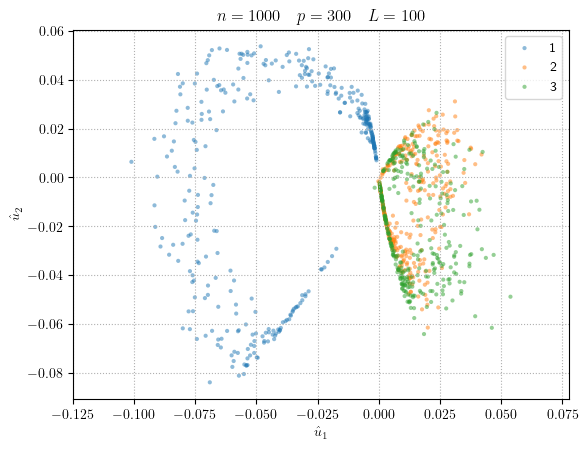

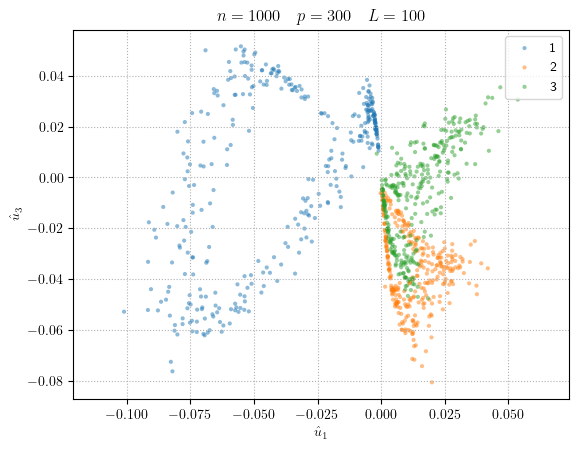

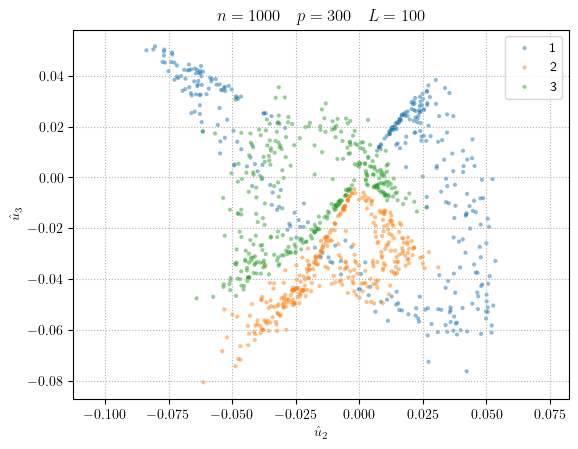

In [10]:
to_plot = np.array([[0, 1], [0, 2], [1, 2]])
to_plot = spikes_idx_t[to_plot] if easy_setting else n-1-to_plot

for i, [a, b] in enumerate(to_plot):
    for j in range(k):
        cl = (J[:, j] == 1)
        x, y = eigvecs_t[0, a, cl], eigvecs_t[0, b, cl]
        plt.scatter(x, y, marker='.', edgecolors='none', alpha=.5, label=j+1)
    plt.grid(ls=':')
    plt.axis('equal')
    plt.xlabel("$\\hat{{u}}_{{{}}}$".format(n-a))
    plt.ylabel("$\\hat{{u}}_{{{}}}$".format(n-b))
    plt.legend()
    plt.title(setting)
    plt.show()

# Classification

In [11]:
if easy_setting:
    print("Optimal classification error: {:.2%}".format(stats.norm.sf(np.sqrt(zeta_t[0]/(1-zeta_t[0])))))

In [12]:
idx_eigvecs = [-1, -2, -3, -4, -5] # eigenvectors used for the classification
idx_basis = [-1, -2, -3, -4, -5, 0] # Toeplitz basis

In [13]:
%%timeit
partition, (exp_smooth, partition0, reg, curves) = utils.classification(k, eigvecs_t[0, idx_eigvecs], basis_t[idx_basis])

34.4 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
partition, (exp_smooth, partition0, reg, curves) = utils.classification(k, eigvecs_t[0, idx_eigvecs], basis_t[idx_basis])

In [15]:
permut = np.array(list(permutations(range(k))))
true_partition = np.argmax(J, axis=1)
c_err = np.min([np.mean(p[partition] != true_partition) for p in permut])
print("Classification error: {:.2%}".format(c_err))

Classification error: 0.00%


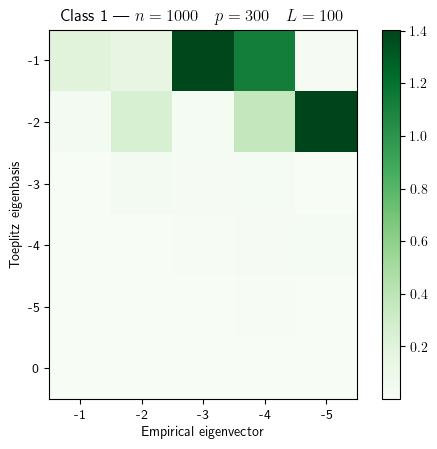

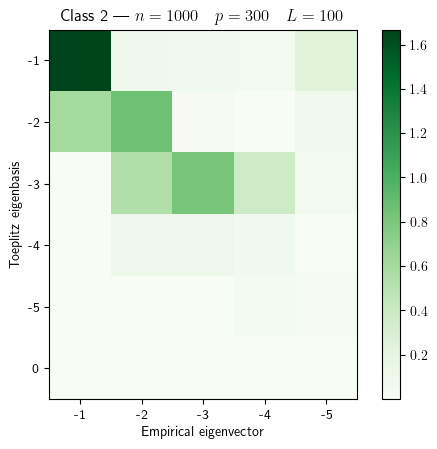

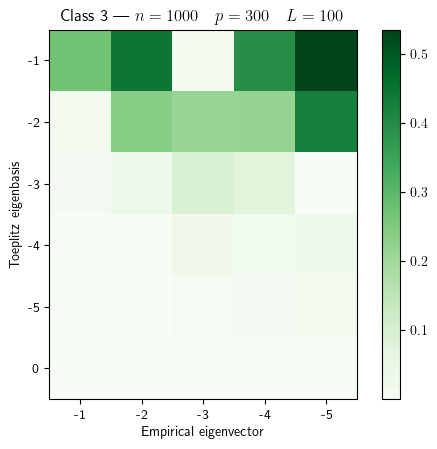

In [16]:
for j in range(k):
    plt.colorbar(plt.imshow(reg[j]**2, interpolation='none', cmap='Greens'))
    plt.xlabel("Empirical eigenvector")
    plt.xticks(ticks=range(reg[j].shape[1]), labels=idx_eigvecs)
    plt.ylabel("Toeplitz eigenbasis")
    plt.yticks(ticks=range(reg[j].shape[0]), labels=idx_basis)
    plt.title("Class {} | ".format(j+1)+setting)
    plt.show()

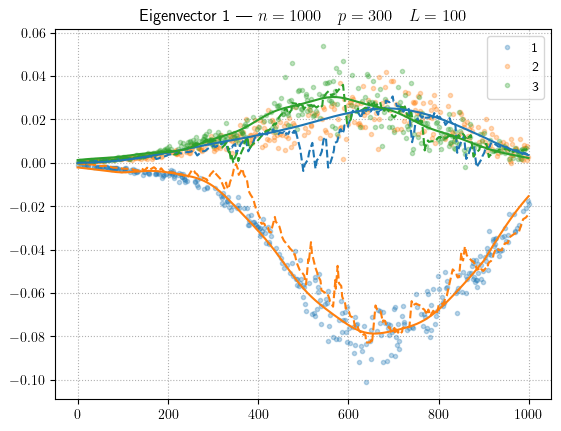

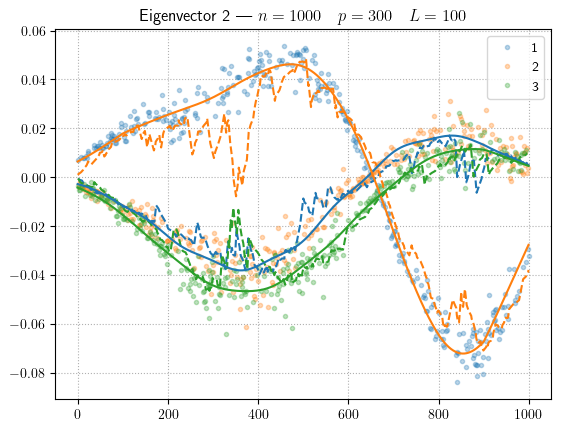

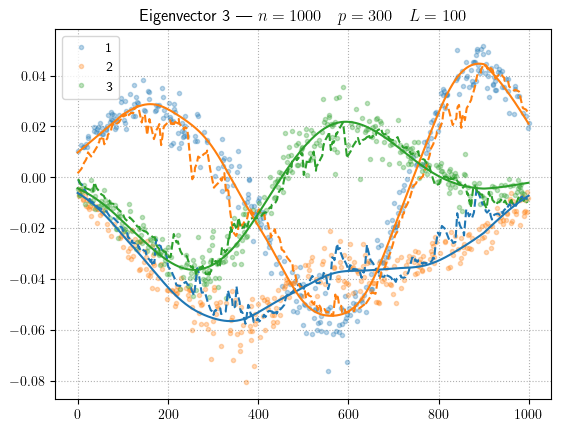

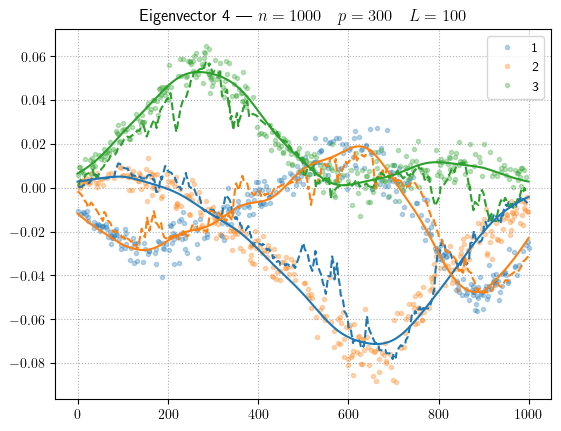

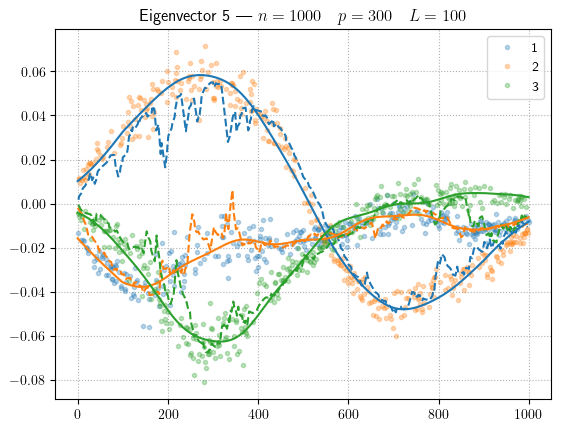

In [17]:
plot_true = True

x = np.arange(n)
for ll, l in enumerate(idx_eigvecs):
    for j in range(k):
        color = 'C'+str(j)
        cl = (J[:, j] == 1) if plot_true else (partition == j)
        plt.plot(x[cl], eigvecs_t[0, l, cl], ls='', marker='.', label=j+1, alpha=.3, c=color, zorder=2)
        plt.plot(x[partition0 == j], exp_smooth[ll, partition0 == j], ls='--', c=color, zorder=3)
        plt.plot(x, curves[j, ll], ls='-', c=color, zorder=4)
    plt.grid(ls=':')
    plt.legend()
    plt.title("Eigenvector {} | ".format((n-l)%n)+setting)
    plt.show()

# Streaming

In [18]:
if streaming:
    n_eigvecs = 5
    idx_basis = [-1, -2, -3, -4, -5]
    
    streaming_setting = "$T = {} \\quad$".format(T)+setting
    
    JT = utils.getJ(T, pi)
    class_count, (lbda, w, exp_smoothT, partition0T, curvesT, partition_ite, time_ite) = utils.simul_streaming(L, M, JT, n_eigvecs, basis_t[idx_basis], h_start=50)
    partitionT = np.argmax(class_count, axis=1)

    permut = np.array(list(permutations(range(k))))
    true_partitionT = np.argmax(JT, axis=1)
    c_errT_list = [np.mean(p[partitionT] != true_partitionT) for p in permut]
    pT = permut[np.argmin(c_errT_list)]
    pT_inv = np.argsort(pT)
    c_errT = np.min(c_errT_list)
    print("Classification error: {:.2%}".format(c_errT))

    delay_c_errT = np.mean(pT[partition_ite[n-1:]] != np.array([true_partitionT[t:t+n] for t in range(T-n+1)]), axis=0)[::-1]

100%|██████████| 10000/10000 [07:24<00:00, 22.47it/s]


Classification error: 6.23%


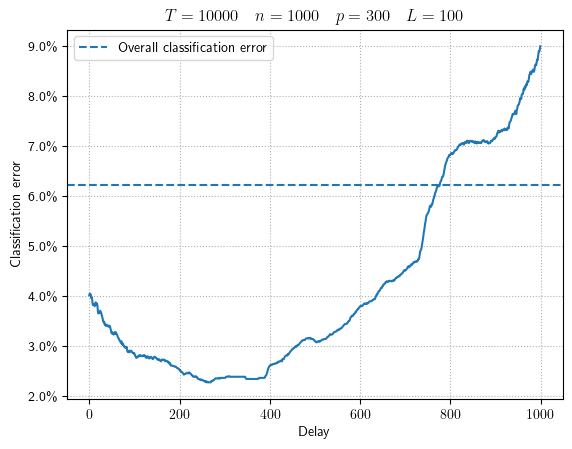

In [19]:
if streaming:
    plt.plot(delay_c_errT)
    plt.axhline(y=c_errT, ls='--', label="Overall classification error")
    plt.grid(ls=':')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.xlabel("Delay")
    plt.ylabel("Classification error")
    plt.title(streaming_setting)
    plt.legend()
    plt.show()

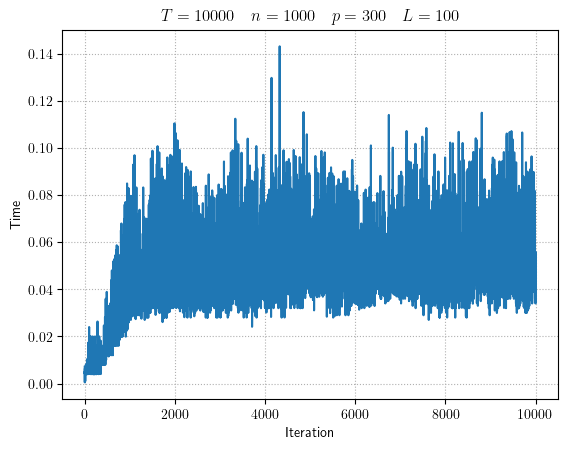

In [20]:
if streaming:
    plt.plot(time_ite)
    plt.grid(ls=':')
    plt.xlabel("Iteration")
    plt.ylabel("Time")
    plt.title(streaming_setting)
    plt.show()

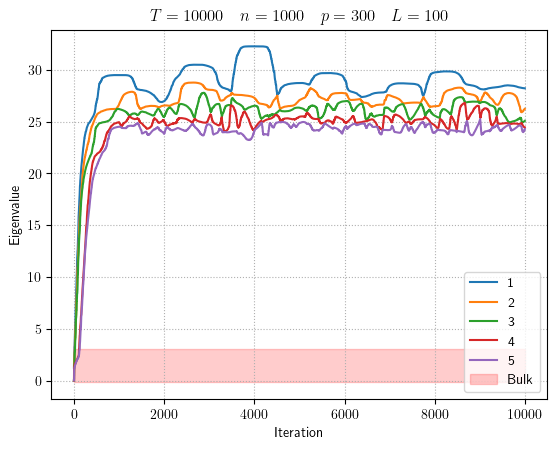

In [21]:
if streaming:
    for i in range(n_eigvecs):
        plt.plot(lbda[i], label=i+1)
    plt.fill_between([0, T], axr[LSD_t > 1e-5][0], axr[LSD_t > 1e-5][-1], alpha=0.2, color='red', label="Bulk")
    plt.grid(ls=':')
    plt.xlabel("Iteration")
    plt.ylabel("Eigenvalue")
    plt.title(streaming_setting)
    plt.legend()
    plt.show()

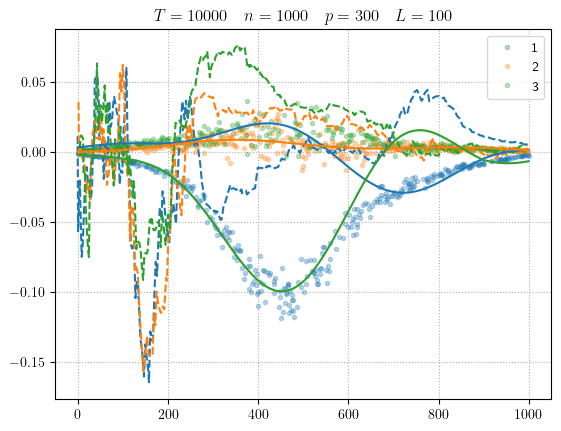

In [22]:
if streaming:
    # t = T//2
    t = n-1
    i = 0

    x = np.arange(max(0, t-n+1), max(n, t+1))
    for j in range(k):
        color = 'C'+str(j)
        cl = (JT[max(0, t-n+1):t+1, j] == 1)
        cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
        plt.plot(x[cl], w[t, i, cl], ls='', marker='.', alpha=.3, c=color, label=j+1, zorder=2)
        if t <= n-1:
            mask = ((x <= t) & (partition0T == pT_inv[j]))
            plt.plot(x[mask], exp_smoothT[i, mask], ls='--', c=color, zorder=3)
        if t >= n-1:
            plt.plot(x, curvesT[t, pT_inv[j], i], c=color, zorder=4)
    plt.grid(ls=':')
    plt.title(streaming_setting)
    plt.legend()
    plt.show()

In [23]:
if animation:
    i = 0

    fig, ax = plt.subplots()

    for j in range(k):
        color = 'C'+str(j)
        ax.plot([], ls='', marker='.', label=j, c=color)
        ax.plot([], ls='--', c=color)
        ax.plot([], ls='-', c=color)
    ax.grid(ls=':')
    ax.set_title(streaming_setting)
    ax.legend()

    def animate(t):
        x = np.arange(max(0, t-n+1), max(n, t+1))
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim((w[t, i].min(), w[t, i].max()))
        for j in range(k):
            cl = (JT[max(0, t-n+1):t+1, j] == 1)
            cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
            ax.lines[3*j].set_data((x[cl], w[t, i, cl]))
            if t <= n-1:
                mask = ((x <= t) & (partition0T == pT_inv[j]))
                ax.lines[3*j+1].set_data((x[mask], exp_smoothT[i, mask]))
            if t >= n-1:
                ax.lines[3*j+2].set_data((x, curvesT[t, pT_inv[j], i]))

    anim = FuncAnimation(fig, animate, frames=T, interval=30*1000/T, repeat=False)
    anim.save("streaming.mp4")